In [149]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    if not os.path.isdir("./images/%s"%(CHAPTER_ID)):
        os.makedirs("./images/%s"%(CHAPTER_ID))
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [150]:
import tensorflow as tf

## Basic RNNs

In [151]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [152]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [153]:
print(Y0_val)

[[-0.0664006   0.96257669  0.68105787  0.70918542 -0.89821595]
 [ 0.9977755  -0.71978885 -0.99657625  0.9673925  -0.99989718]
 [ 0.99999774 -0.99898815 -0.99999893  0.99677622 -0.99999988]
 [ 1.         -1.         -1.         -0.99818915  0.99950868]]


In [154]:
print(Wx)

<tf.Variable 'Variable:0' shape=(3, 5) dtype=float32_ref>


## Using static_rnn()

In [155]:
n_inputs = 3
n_neurons = 5

In [156]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(
                            basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

In [157]:
init = tf.global_variables_initializer()

In [158]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [159]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425421, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [160]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [161]:
show_graph(tf.get_default_graph())

## Packing sequences

In [162]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [163]:
reset_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0 ,2]))
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(
                        basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [164]:
init = tf.global_variables_initializer()

In [165]:
X_batch = np.array([
      # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [166]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]]

 [[-0.80015349 -0.99218267  0.78177971  0.9971031  -0.99646091]
  [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]]

 [[-0.93605185 -0.99983788  0.93088669  0.99998152 -0.99998295]
  [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]]

 [[ 0.99273688 -0.99819332 -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]]


In [167]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]
 [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]
 [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]
 [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]


## Using `dynamic_rnn()`

In [168]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [169]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)


In [170]:
init = tf.global_variables_initializer()

In [171]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [172]:
print(outputs_val)

[[[ 0.80872238 -0.52312446 -0.6716494  -0.69762248 -0.54384488]
  [ 0.9995454   0.99339807 -0.99998379  0.99919224 -0.98379493]]

 [[ 0.99547106 -0.02155113 -0.99482894  0.17964774 -0.83173698]
  [-0.06013332  0.4030143   0.02884481 -0.29437575 -0.85681593]]

 [[ 0.99990267  0.49111056 -0.9999314   0.8413834  -0.9444679 ]
  [ 0.99406189  0.95815992 -0.99768937  0.98646194 -0.91752487]]

 [[-0.80632919  0.93928123 -0.97309881  0.99996096  0.97433066]
  [ 0.95047355 -0.51205158 -0.27763969  0.83108062  0.81631833]]]


In [173]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [174]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [175]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [176]:
init = tf.global_variables_initializer()

In [177]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [178]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [179]:
print(outputs_val)

[[[ 0.04335003 -0.7907052   0.62847102 -0.16162854  0.82851923]
  [-0.23427293 -0.98320025  1.          0.05531176  0.13038807]]

 [[ 0.06481666 -0.98885179  0.99938971 -0.2837334   0.94707835]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.0862233  -0.9994626   0.99999934 -0.39728162  0.9843685 ]
  [-0.3956297  -0.49045283  0.99999118  0.26839557 -0.66423571]]

 [[-0.99486166  0.99336135  0.9999935   0.9048987  -0.99997759]
  [ 0.65352577 -0.56341326  0.99020594  0.72314984  0.30071661]]]


In [180]:
print(states_val)

[[-0.23427293 -0.98320025  1.          0.05531176  0.13038807]
 [ 0.06481666 -0.98885179  0.99938971 -0.2837334   0.94707835]
 [-0.3956297  -0.49045283  0.99999118  0.26839557 -0.66423571]
 [ 0.65352577 -0.56341326  0.99020594  0.72314984  0.30071661]]


## Training a sequence classifier

In [181]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10


learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [182]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)


0 Train accuracy: 0.906667 Test accuracy: 0.9061
1 Train accuracy: 0.953333 Test accuracy: 0.9426
2 Train accuracy: 0.946667 Test accuracy: 0.9535
3 Train accuracy: 0.96 Test accuracy: 0.9623
4 Train accuracy: 0.966667 Test accuracy: 0.9704
5 Train accuracy: 0.966667 Test accuracy: 0.9637
6 Train accuracy: 0.993333 Test accuracy: 0.9731
7 Train accuracy: 0.98 Test accuracy: 0.9657
8 Train accuracy: 0.98 Test accuracy: 0.9745
9 Train accuracy: 0.986667 Test accuracy: 0.9763
10 Train accuracy: 0.986667 Test accuracy: 0.9748
11 Train accuracy: 0.966667 Test accuracy: 0.9709
12 Train accuracy: 0.98 Test accuracy: 0.9764
13 Train accuracy: 0.966667 Test accuracy: 0.9738
14 Train accuracy: 0.986667 Test accuracy: 0.9715
15 Train accuracy: 0.993333 Test accuracy: 0.977
16 Train accuracy: 0.98 Test accuracy: 0.9734
17 Train accuracy: 0.986667 Test accuracy: 0.9715
18 Train accuracy: 0.986667 Test accuracy: 0.9718
19 Train accuracy: 0.986667 Test accuracy: 0.9783
20 Train accuracy: 0.98 Test ac

## Time series

In [183]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


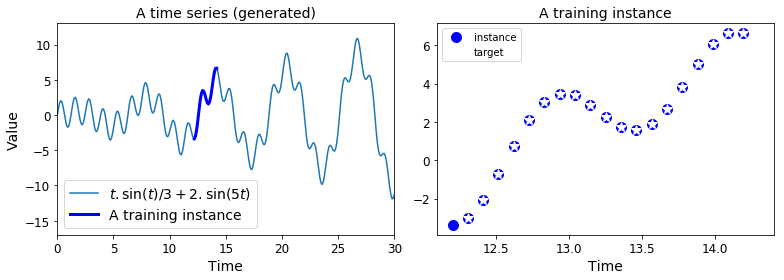

In [184]:

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [185]:
X_batch, y_batch = next_batch(1, n_steps)

In [186]:
np.c_[X_batch[0], y_batch[0]]

array([[-1.40208096, -2.33035999],
       [-2.33035999, -3.4513234 ],
       [-3.4513234 , -4.52641909],
       [-4.52641909, -5.32081479],
       [-5.32081479, -5.66045846],
       [-5.66045846, -5.47433377],
       [-5.47433377, -4.81157012],
       [-4.81157012, -3.82922233],
       [-3.82922233, -2.75371563],
       [-2.75371563, -1.82539786],
       [-1.82539786, -1.23977629],
       [-1.23977629, -1.0998269 ],
       [-1.0998269 , -1.39105208],
       [-1.39105208, -1.98539218],
       [-1.98539218, -2.67303091],
       [-2.67303091, -3.214304  ],
       [-3.214304  , -3.39899794],
       [-3.39899794, -3.09851497],
       [-3.09851497, -2.29812628],
       [-2.29812628, -1.10140997]])

## Using an `OuputProjectionWrapper`

In [187]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [188]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [189]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [190]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [191]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [192]:
saver = tf.train.Saver()

In [194]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.8245
100 	MSE: 0.578066
200 	MSE: 0.1761
300 	MSE: 0.0861073
400 	MSE: 0.0657614
500 	MSE: 0.0664743
600 	MSE: 0.0553975
700 	MSE: 0.0497011
800 	MSE: 0.0511938
900 	MSE: 0.0484837
1000 	MSE: 0.048555
1100 	MSE: 0.0494415
1200 	MSE: 0.0415821
1300 	MSE: 0.048374
1400 	MSE: 0.0427685


In [195]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [196]:
y_pred

array([[[-3.41475916],
        [-2.44340444],
        [-1.04039109],
        [ 0.7025364 ],
        [ 2.19097877],
        [ 3.09468389],
        [ 3.58234119],
        [ 3.38148832],
        [ 2.83516598],
        [ 2.15455389],
        [ 1.71032345],
        [ 1.59078062],
        [ 1.97905934],
        [ 2.75026083],
        [ 3.8643465 ],
        [ 5.06522608],
        [ 6.12907171],
        [ 6.70195818],
        [ 6.66509771],
        [ 6.04591227]]], dtype=float32)

Saving figure time_series_pred_plot


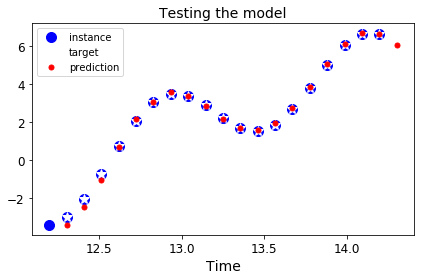

In [197]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [198]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [199]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs , states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [200]:
n_outputs = 1
learning_rate = 0.001

In [201]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [202]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [203]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 14.4271
100 	MSE: 0.57318
200 	MSE: 0.213021
300 	MSE: 0.11726
400 	MSE: 0.070781
500 	MSE: 0.0643272
600 	MSE: 0.0559673
700 	MSE: 0.0513259
800 	MSE: 0.0540262
900 	MSE: 0.0486771
1000 	MSE: 0.0491915
1100 	MSE: 0.0501978
1200 	MSE: 0.0427164
1300 	MSE: 0.0484563
1400 	MSE: 0.0438531


In [204]:
y_pred

array([[[-3.44828582],
        [-2.48405623],
        [-1.13649726],
        [ 0.71962416],
        [ 2.01745081],
        [ 3.13937259],
        [ 3.54828739],
        [ 3.36234236],
        [ 2.77184248],
        [ 2.10781217],
        [ 1.64527285],
        [ 1.5579648 ],
        [ 1.87219918],
        [ 2.7233479 ],
        [ 3.85228252],
        [ 5.06193066],
        [ 6.07513857],
        [ 6.63054752],
        [ 6.59069633],
        [ 5.9993453 ]]], dtype=float32)

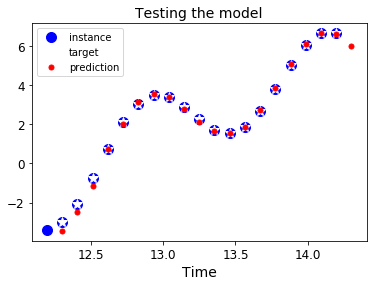

In [205]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Creative RNN

In [206]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)  
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ./my_time_series_model


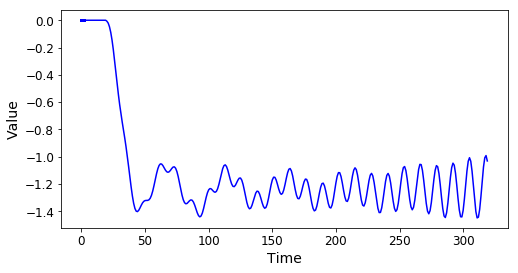

In [207]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


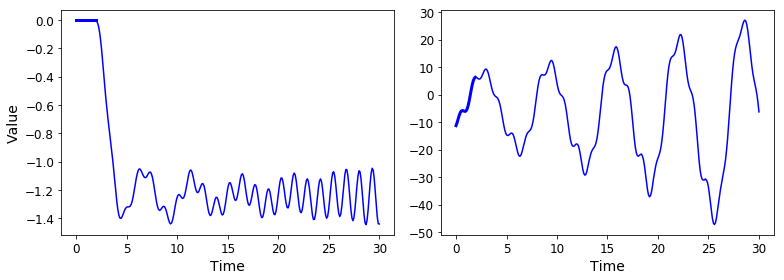

In [208]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

# Deep RNN
## MultiRNNCell

In [209]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [210]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [211]:
init = tf.global_variables_initializer()

## Distributing a Deep RNN Across Multiple GPUs

In [212]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
    def __init__(self, device, cell):
        self._cell = cell
        self._device = device
        
    @property
    def state_size(self):
        return self._cell.state_size
    
    @property
    def output_size(self):
        return self._cell.output_size

    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):
            return self._cell(inputs, state, scope)

In [213]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [214]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [215]:
init = tf.global_variables_initializer()

In [216]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-0.08663084 -0.0929317  -0.09448218 ...,  0.07095756  0.03947859
   -0.0223582 ]
  [-0.00272523 -0.34017661  0.05924866 ..., -0.06484335  0.113869
    0.1355288 ]
  [ 0.02946341 -0.24840435  0.05619801 ..., -0.16343941  0.04593967
    0.129195  ]
  ..., 
  [ 0.05272572 -0.53788346  0.48113257 ..., -0.06051829 -0.07264125
    0.468768  ]
  [-0.50525427 -0.76852441  0.45592368 ...,  0.01245521  0.11499207
    0.62669986]
  [ 0.03964036 -0.7981301   0.6590758  ..., -0.25132325  0.11016278
    0.48127082]]

 [[-0.1513125  -0.08667991  0.00700863 ...,  0.07468764 -0.0023026
   -0.04307155]
  [ 0.07644141 -0.29120383 -0.03115539 ..., -0.07067543  0.06400656
    0.08548108]
  [-0.04945162 -0.19338506  0.10298084 ...,  0.02510141 -0.02033011
    0.1503721 ]
  ..., 
  [-0.31397206 -0.74376661  0.4937177  ...,  0.06411301  0.28450167
    0.34879085]
  [ 0.18476257 -0.74396408  0.32966781 ..., -0.33429959 -0.28992158
    0.40368894]
  [-0.09950478 -0.60919178  0.55980897 ...,  0.04178806  0.13

## Dropout

In [217]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_inputs])




In [218]:
keep_prob = 0.5

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
        for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
             for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [219]:
learing_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [220]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            print(iteration, "Training MSE:", mse)
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 15.3505
100 Training MSE: 4.71498
200 Training MSE: 5.73098
300 Training MSE: 3.53693
400 Training MSE: 2.51812
500 Training MSE: 3.14653
600 Training MSE: 3.15242
700 Training MSE: 3.21124
800 Training MSE: 2.72464
900 Training MSE: 2.94664


In [221]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

keep_prob = 0.5

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


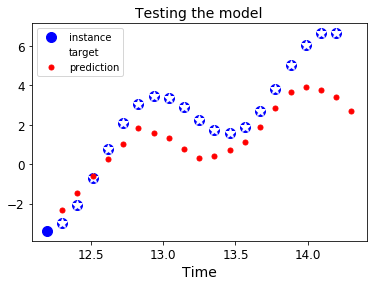

In [222]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [223]:
reset_graph()

import sys
training = True  # in a script, this would be (sys.argv[-1] == "train") instead

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
if training:
    cells = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
             for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])    # not shown in the book
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) # not shown
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])   # not shown
loss = tf.reduce_mean(tf.square(outputs - y))                     # not shown
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)   # not shown
training_op = optimizer.minimize(loss)                            # not shown
init = tf.global_variables_initializer()                          # not shown
saver = tf.train.Saver()                                          # not shown

with tf.Session() as sess:
    if training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)    # not shown
            _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch}) # not shown
            if iteration % 100 == 0:                              # not shown
                print(iteration, "Training MSE:", mse)            # not shown
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs))) # not shown
        y_pred = sess.run(outputs, feed_dict={X: X_new})                              # not shown

0 Training MSE: 15.431
100 Training MSE: 4.3993
200 Training MSE: 4.70966
300 Training MSE: 4.4399
400 Training MSE: 3.68318
500 Training MSE: 3.94874
600 Training MSE: 3.75045
700 Training MSE: 3.49528
800 Training MSE: 3.06347
900 Training MSE: 4.01044


## LSTM Cell

In [224]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [225]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])


lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()


In [226]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [227]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [228]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.966667 Test accuracy = 0.9535


KeyboardInterrupt: 

# Embeddings

## Fetch the data

In [238]:
from six.moves import urllib

import errno
import os
import zipfile


WORDS_PATH = "datasets/words"
WORDS_URL = "http://mattmahoney.net/dc/text8.zip"

def mkdir_p(path):
    os.makedirs(path)
    
def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [239]:
words = fetch_words_data()

In [240]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [242]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [243]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [246]:
" ".join([vocabulary[word_index] for word_index in [5234, 3081,   12,    6,  195,    2, 3134,   46,   59]])

'anarchism originated as a term of abuse first used'

In [247]:
words[24], data[24]

('culottes', 0)